In [1]:
import sys
sys.path.append('../../')
from simCRN.multivariate_reg import read_eq_data_file
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from hyperopt import hp
from hyperopt import fmin, tpe, space_eval, Trials
from sklearn.model_selection import cross_val_score

# Baseline model: Random Forest

In [3]:
np.seterr(under='warn')

{'divide': 'warn', 'over': 'warn', 'under': 'warn', 'invalid': 'warn'}

Reading in the data

In [4]:
Ci_all_array, Am_array, Cmin, Cmax, Ai = read_eq_data_file('../20-20-2-asym-AB-AC.txt')

In [5]:
print(Cmax)

1.5e-06


In [6]:
Am_array.shape

(3000, 20)

Prepare the data

In [7]:
# Splitting into train and test
X_train, X_test, y_train, y_test = train_test_split(Am_array, Ci_all_array, test_size=0.2, random_state=0)

Random Forest Model

In [8]:
random_forest_model = RandomForestRegressor(criterion="squared_error", random_state=0)
tt_regressor = TransformedTargetRegressor(regressor=random_forest_model, transformer=StandardScaler())
pipeline = Pipeline([('x_scaler', StandardScaler()), ('regressor', tt_regressor)])

pipeline.fit(X_train, y_train)
y_hat_train = pipeline.predict(X_train)
y_hat_test = pipeline.predict(X_test)

In [9]:
train_mae = mae(y_train, y_hat_train, multioutput='raw_values')
test_mae = mae(y_test, y_hat_test, multioutput='raw_values')

print(f'The MAE on the training data for C₁ is {train_mae[0]:.3}') # 3 significant figures
print(f'The MAE on the training data for C₂ is {train_mae[1]:.3}')
print(f'The MAE on the test data for C₁ is {test_mae[0]:.3}')
print(f'The MAE on the test data for C₂ is {test_mae[1]:.3}')

print() # new line

# Contextualizing with the mean of C₁ and C₂
means = np.mean(Ci_all_array, axis=0)
print(f'The average value of C₁ is {means[0]:.3}')
print(f'The average value of C₂ is {means[1]:.3}')

print() # new line

print(f'For the test data, MAE/mean for C₁ is {test_mae[0]/means[0]:.3}')
print(f'For the test data, MAE/mean for C₂ is {test_mae[1]/means[1]:.3}')

The MAE on the training data for C₁ is 2.13e-09
The MAE on the training data for C₂ is 2.32e-09
The MAE on the test data for C₁ is 4.99e-09
The MAE on the test data for C₂ is 5.39e-09

The average value of C₁ is 7.62e-07
The average value of C₂ is 7.5e-07

For the test data, MAE/mean for C₁ is 0.00656
For the test data, MAE/mean for C₂ is 0.00718


In [10]:
train_mse = mse(y_train, y_hat_train, multioutput='raw_values')
test_mse = mse(y_test, y_hat_test, multioutput='raw_values')
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

print(f'The RMSE on the training data for C₁ is {train_rmse[0]:.3}') # 3 significant figures
print(f'The RMSE on the training data for C₂ is {train_rmse[1]:.3}')
print(f'The RMSE on the test data for C₁ is {test_rmse[0]:.3}')
print(f'The RMSE on the test data for C₂ is {test_rmse[1]:.3}')

print() # new line

# Contextualizing with the mean of C₁ and C₂
print(f'The average value of C₁ is {means[0]:.3}')
print(f'The average value of C₂ is {means[1]:.3}')

print() # new line

print(f'For the test data, RMSE/mean for C₁ is {test_rmse[0]/means[0]:.3}')
print(f'For the test data, RMSE/mean for C₂ is {test_rmse[1]/means[1]:.3}')

The RMSE on the training data for C₁ is 2.9e-09
The RMSE on the training data for C₂ is 3.1e-09
The RMSE on the test data for C₁ is 6.94e-09
The RMSE on the test data for C₂ is 7.18e-09

The average value of C₁ is 7.62e-07
The average value of C₂ is 7.5e-07

For the test data, RMSE/mean for C₁ is 0.00911
For the test data, RMSE/mean for C₂ is 0.00957


In [11]:
train_r2 = r2_score(y_train, y_hat_train, multioutput='raw_values')
test_r2 = r2_score(y_test, y_hat_test, multioutput='raw_values')

print(f'The R² on the training data for C₁ is {train_r2[0]:.3}') # 3 significant figures
print(f'The R² on the training data for C₂ is {train_r2[1]:.3}')
print(f'The R² on the test data for C₁ is {test_r2[0]:.3}')
print(f'The R² on the test data for C₂ is {test_r2[1]:.3}')

The R² on the training data for C₁ is 1.0
The R² on the training data for C₂ is 1.0
The R² on the test data for C₁ is 1.0
The R² on the test data for C₂ is 1.0


# Hyperparameter optimization

In [12]:
n_estimators_list = [20, 40, 80, 100, 160, 320, 640, 1280]
min_samples_split_list = [2, 8, 10, 12, 24]
max_depth_list = [2, 4, 8, 10, None]
max_depth_list = [2, 4, 8, 10, None]
parameter_space = {'n_estimators': hp.choice('n_estimators', n_estimators_list), \
                   'min_samples_split': hp.choice('min_samples_split', min_samples_split_list), \
                   'max_depth': hp.choice('max_depth', max_depth_list)}

In [13]:
print(f"Parameter Space Size: {len(n_estimators_list)*len(min_samples_split_list)*len(max_depth_list)}")

Parameter Space Size: 200


In [14]:
from hyperopt import hp
from hyperopt import fmin, tpe, space_eval, Trials
from sklearn.model_selection import cross_val_score

In [15]:
def model_eval(args):

    '''Take suggested arguments and perform model evaluation'''
    
    random_forest_model = RandomForestRegressor(criterion="squared_error", n_estimators=args['n_estimators'], \
                                  min_samples_split=args['min_samples_split'], max_depth=args['max_depth'])
    tt_regressor = TransformedTargetRegressor(regressor=random_forest_model, transformer=StandardScaler())
    pipeline = Pipeline([('x_scaler', StandardScaler()), ('regressor', tt_regressor)])
    
    scores = cross_val_score(pipeline, X_train, y=y_train, scoring='neg_mean_squared_error')
    
    cv_score = np.mean(scores)

    # return the negative of the CV score to ensure we maximize the negative MSE by minimizing the loss
    return -cv_score

In [17]:
print("Start trials") 

trials = Trials()
best = fmin(model_eval, parameter_space, algo=tpe.suggest, max_evals=200, trials=trials)

Start trials
100%|██████████| 200/200 [4:29:33<00:00, 80.87s/trial, best loss: 5.8071544686054e-17]   


In [18]:
print("Best parameter set: {}".format(best))
print(f"n_estimators = {n_estimators_list[best['n_estimators']]}")
print(f"max_depth = {max_depth_list[best['max_depth']]}")
print(f"min_samples_split = {min_samples_split_list[best['min_samples_split']]}")
print("Best loss from CV: {:.3}".format(trials.best_trial['result']['loss']))
print("Best RMSE loss from CV: {:.3}".format(np.sqrt(trials.best_trial['result']['loss'])))

Best parameter set: {'max_depth': 4, 'min_samples_split': 0, 'n_estimators': 7}
n_estimators = 1280
max_depth = None
min_samples_split = 2
Best loss from CV: 5.81e-17
Best RMSE loss from CV: 7.62e-09


# Train Optimized Model

In [19]:
from sklearn.model_selection import cross_validate

In [20]:
parameter_dict = {'n_estimators': n_estimators_list, 'min_samples_split': min_samples_split_list, \
                  'max_depth': max_depth_list}

In [21]:
def optimized_model_eval(X_train, y_train, X_test, y_test, parameters, parameter_dict):

    '''Take suggested arguments and perform model evaluation'''

    random_forest_model = RandomForestRegressor(criterion="squared_error", \
                                                n_estimators=parameter_dict['n_estimators'][parameters['n_estimators']], \
                                                min_samples_split=parameter_dict['min_samples_split'][parameters['min_samples_split']], \
                                                max_depth=parameter_dict['max_depth'][parameters['max_depth']])
    tt_regressor = TransformedTargetRegressor(regressor=random_forest_model, transformer=StandardScaler())
    pipeline = Pipeline([('x_scaler', StandardScaler()), ('regressor', tt_regressor)])

    # Train 5 models on random 80/20 test splits of the input data
    scores = cross_validate(pipeline, X_train, y=y_train, scoring=['neg_mean_squared_error', 'neg_mean_absolute_error'], \
                             return_estimator=True)
    
    # Get average validation MSE
    mean_val_mse = -np.mean(scores['test_neg_mean_squared_error'])
    mean_val_mae = -np.mean(scores['test_neg_mean_absolute_error'])
    
    # Calculate test MSE
    test_mse_arr = np.zeros((5,2))
    test_mae_arr = np.zeros((5,2))
    for i in range(5):
        y_test_pred = scores['estimator'][i].predict(X_test)
        test_mse_arr[i,:] = mse(y_test, y_test_pred, multioutput='raw_values')
        test_mae_arr[i,:] = mae(y_test, y_test_pred, multioutput='raw_values')
    mean_test_mse = np.mean(test_mse_arr)
    mean_test_mae = np.mean(test_mae_arr)
    

    # return the negative of the CV score to ensure we maximize the negative MSE by minimizing the loss
    return scores, mean_val_mse, mean_val_mae, test_mse_arr, test_mae_arr, mean_test_mse, mean_test_mae

In [22]:
optimized_scores, optimized_val_mse, optimized_val_mae, optimized_test_mse_arr, optimized_test_mae_arr, \
optimized_mean_test_mse, optimized_mean_test_mae \
= optimized_model_eval(X_train, y_train, X_test, y_test, best, parameter_dict)

In [23]:
print(f"Optimized average validation MSE: {optimized_val_mse:.3}")
print(f"Optimized average validation RMSE: {np.sqrt(optimized_val_mse):.3}")
print(f"Optimized average validation MAE: {optimized_val_mae:.3}")

Optimized average validation MSE: 5.86e-17
Optimized average validation RMSE: 7.66e-09
Optimized average validation MAE: 5.45e-09


In [24]:
print(f"Optimized average test MSE: {optimized_mean_test_mse:.3}")
print(f"Optimized average test RMSE: {np.sqrt(optimized_mean_test_mse):.3}")
print(f"Optimized average test MAE: {optimized_mean_test_mae:.3}")

Optimized average test MSE: 5.39e-17
Optimized average test RMSE: 7.34e-09
Optimized average test MAE: 5.26e-09


In [31]:
print(f"Optimized average validation MSE: {optimized_val_mse}")
print(f"Optimized average validation RMSE: {np.sqrt(optimized_val_mse)}")
print(f"Optimized average validation MAE: {optimized_val_mae}")
print(f"Optimized average test MSE: {optimized_mean_test_mse}")
print(f"Optimized average test RMSE: {np.sqrt(optimized_mean_test_mse)}")
print(f"Optimized average test MAE: {optimized_mean_test_mae}")

Optimized average validation MSE: 5.864018040983154e-17
Optimized average validation RMSE: 7.65768766729432e-09
Optimized average validation MAE: 5.4538500022070806e-09
Optimized average test MSE: 5.3860834483037643e-17
Optimized average test RMSE: 7.338994105668545e-09
Optimized average test MAE: 5.258369695279548e-09


# Reducing Dataset Size

In [25]:
def prep_data(X, y, total_size, test_size, random_state):
    # Calculate the size of the reduced data set
    total_frac = total_size/y.shape[0]
    # Reducing the dataset size
    X_train_all, X_test_all, y_train_all, y_test_all = \
    train_test_split(X, y, test_size=1-total_frac, random_state=random_state)
    
    # Splitting into train and test
    X_train, X_test, y_train, y_test = \
    train_test_split(X_train_all, y_train_all, test_size=test_size, random_state=random_state)
    
    return(X_train, X_test, X_test_all, y_train, y_test, y_test_all)

In [26]:
# Reduced data set sizes
data_set_sizes = 3000*(2/3)*0.5 ** np.arange(0,6)
print(data_set_sizes)
# Lists to store data and results in
trials_list = []
best_params_list = []
X_train_list = []
X_test_list = []
X_test_all_list = []
y_train_list = []
y_test_list = []
y_test_all_list = []

[2000.  1000.   500.   250.   125.    62.5]


In [27]:
# Iterate through smaller data set sizes
for data_set_size in data_set_sizes:
    print(f"Data set size: {data_set_size}")
    X_train_sub, X_test_sub, X_test_all, y_train_sub, y_test_sub, y_test_all = \
    prep_data(X_train, y_train, data_set_size, 0.2, 0)
    # Add data sets to lists
    X_train_list.append(X_train_sub)
    X_test_list.append(X_test_sub)
    X_test_all_list.append(X_test_all)
    y_train_list.append(y_train_sub)
    y_test_list.append(y_test_sub)
    y_test_all_list.append(y_test_all)
    def model_eval_data_set(args):

        '''Take suggested arguments and perform model evaluation'''

        random_forest_model = RandomForestRegressor(criterion="squared_error", n_estimators=args['n_estimators'], \
                                      min_samples_split=args['min_samples_split'], max_depth=args['max_depth'])
        tt_regressor = TransformedTargetRegressor(regressor=random_forest_model, transformer=StandardScaler())
        pipeline = Pipeline([('x_scaler', StandardScaler()), ('regressor', tt_regressor)])

        scores = cross_val_score(pipeline, X_train_sub, y=y_train_sub, scoring='neg_mean_squared_error')

        cv_score = np.mean(scores)

        # return the negative of the CV score to ensure we maximize the negative MSE by minimizing the loss
        return -cv_score
    # Hyperparameter optimize
    trials = Trials()
    best = fmin(model_eval_data_set, parameter_space, algo=tpe.suggest, max_evals=200, trials=trials)
    trials_list.append(trials)
    best_params_list.append(best)
    print("Best parameter set: {}".format(best))
    print(f"n_estimators = {n_estimators_list[best['n_estimators']]}")
    print(f"max_depth = {max_depth_list[best['max_depth']]}")
    print(f"min_samples_split = {min_samples_split_list[best['min_samples_split']]}")

Data set size: 2000.0
100%|██████████| 200/200 [1:23:03<00:00, 24.92s/trial, best loss: 9.495829586714451e-17]
Best parameter set: {'max_depth': 4, 'min_samples_split': 0, 'n_estimators': 7}
n_estimators = 1280
max_depth = None
min_samples_split = 2
Data set size: 1000.0
100%|██████████| 200/200 [56:23<00:00, 16.92s/trial, best loss: 2.426566540928194e-16]  
Best parameter set: {'max_depth': 4, 'min_samples_split': 0, 'n_estimators': 7}
n_estimators = 1280
max_depth = None
min_samples_split = 2
Data set size: 500.0
100%|██████████| 200/200 [22:35<00:00,  6.78s/trial, best loss: 7.015507770097397e-16]
Best parameter set: {'max_depth': 4, 'min_samples_split': 0, 'n_estimators': 6}
n_estimators = 640
max_depth = None
min_samples_split = 2
Data set size: 250.0
100%|██████████| 200/200 [13:40<00:00,  4.10s/trial, best loss: 2.067315097012109e-15]
Best parameter set: {'max_depth': 3, 'min_samples_split': 0, 'n_estimators': 5}
n_estimators = 320
max_depth = 10
min_samples_split = 2
Data set s

In [28]:
best_params_list

[{'max_depth': 4, 'min_samples_split': 0, 'n_estimators': 7},
 {'max_depth': 4, 'min_samples_split': 0, 'n_estimators': 7},
 {'max_depth': 4, 'min_samples_split': 0, 'n_estimators': 6},
 {'max_depth': 3, 'min_samples_split': 0, 'n_estimators': 5},
 {'max_depth': 2, 'min_samples_split': 0, 'n_estimators': 5},
 {'max_depth': 3, 'min_samples_split': 0, 'n_estimators': 7}]

# Train Optimized Models (Reduced Dataset)

In [32]:
mean_val_mse_list = []
mean_val_mae_list = []
mean_test_mse_list = []
mean_test_mae_list = []
for i in range(len(data_set_sizes)):
    scores, mean_val_mse, mean_val_mae, test_mse_arr, test_mae_arr, mean_test_mse, mean_test_mae = \
    optimized_model_eval(X_train_list[i], y_train_list[i], X_test_list[i], y_test_list[i], \
                         best_params_list[i], parameter_dict)
    mean_val_mse_list.append(mean_val_mse)
    mean_val_mae_list.append(mean_val_mae)
    mean_test_mse_list.append(mean_test_mse)
    mean_test_mae_list.append(mean_test_mae)

In [33]:
print("Mean validation MSE list")
print(mean_val_mse_list)
print("Mean validation MAE list")
print(mean_val_mae_list)

Mean validation MSE list
[9.61743464243295e-17, 2.500625128830955e-16, 7.313530559400985e-16, 2.125544219406924e-15, 4.792343515064768e-15, 1.0407203773592203e-14]
Mean validation MAE list
[6.860160407140961e-09, 1.079760156042639e-08, 1.715778472387026e-08, 2.9631465064969705e-08, 4.348072041770237e-08, 6.869039411050913e-08]


In [34]:
for i in range(len(data_set_sizes)):
    print(f"Data set size: {data_set_sizes[i]}")
    print(f"Optimized average validation MSE: {mean_val_mse_list[i]:.3}")
    print(f"Optimized average validation RMSE: {np.sqrt(mean_val_mse_list[i]):.3}")
    print(f"Optimized average validation MAE: {mean_val_mae_list[i]:.3}")

Data set size: 2000.0
Optimized average validation MSE: 9.62e-17
Optimized average validation RMSE: 9.81e-09
Optimized average validation MAE: 6.86e-09
Data set size: 1000.0
Optimized average validation MSE: 2.5e-16
Optimized average validation RMSE: 1.58e-08
Optimized average validation MAE: 1.08e-08
Data set size: 500.0
Optimized average validation MSE: 7.31e-16
Optimized average validation RMSE: 2.7e-08
Optimized average validation MAE: 1.72e-08
Data set size: 250.0
Optimized average validation MSE: 2.13e-15
Optimized average validation RMSE: 4.61e-08
Optimized average validation MAE: 2.96e-08
Data set size: 125.0
Optimized average validation MSE: 4.79e-15
Optimized average validation RMSE: 6.92e-08
Optimized average validation MAE: 4.35e-08
Data set size: 62.5
Optimized average validation MSE: 1.04e-14
Optimized average validation RMSE: 1.02e-07
Optimized average validation MAE: 6.87e-08


In [35]:
print("Mean test MSE list")
print(mean_test_mse_list)
print("Mean test MAE list")
print(mean_test_mae_list)

Mean test MSE list
[1.1574433098144913e-16, 2.0414008148121815e-16, 5.442788580118787e-16, 2.149050856262612e-15, 7.806606802867584e-15, 9.631154015372926e-15]
Mean test MAE list
[7.546573532180684e-09, 1.00353565435267e-08, 1.632662068203244e-08, 3.2483297873086105e-08, 5.156652695995332e-08, 6.172981581536048e-08]


In [36]:
for i in range(len(data_set_sizes)):
    print(f"Data set size: {data_set_sizes[i]}")
    print(f"Optimized average test MSE: {mean_test_mse_list[i]:.3}")
    print(f"Optimized average test RMSE: {np.sqrt(mean_test_mse_list[i]):.3}")
    print(f"Optimized average test MAE: {mean_test_mae_list[i]:.3}")

Data set size: 2000.0
Optimized average test MSE: 1.16e-16
Optimized average test RMSE: 1.08e-08
Optimized average test MAE: 7.55e-09
Data set size: 1000.0
Optimized average test MSE: 2.04e-16
Optimized average test RMSE: 1.43e-08
Optimized average test MAE: 1e-08
Data set size: 500.0
Optimized average test MSE: 5.44e-16
Optimized average test RMSE: 2.33e-08
Optimized average test MAE: 1.63e-08
Data set size: 250.0
Optimized average test MSE: 2.15e-15
Optimized average test RMSE: 4.64e-08
Optimized average test MAE: 3.25e-08
Data set size: 125.0
Optimized average test MSE: 7.81e-15
Optimized average test RMSE: 8.84e-08
Optimized average test MAE: 5.16e-08
Data set size: 62.5
Optimized average test MSE: 9.63e-15
Optimized average test RMSE: 9.81e-08
Optimized average test MAE: 6.17e-08


# Plots

In [37]:
plt.rcParams.update({'font.size': 16})
plot_data_set_sizes = np.array([3000, 2000, 1000, 500, 250, 125, 62.5])
# mean_val_mse_list.insert(0, optimized_val_mse)
# mean_val_mae_list.insert(0, optimized_val_mae)
# mean_test_mse_list.insert(0, optimized_mean_test_mse)
# mean_test_mae_list.insert(0, optimized_mean_test_mae)
print("Validation MSE")
print(mean_val_mse_list)
print("Validation MAE")
print(mean_val_mae_list)
print("Test MSE")
print(mean_test_mse_list)
print("Test MAE")
print(mean_test_mae_list)

Validation MSE
[5.864018040983154e-17, 9.61743464243295e-17, 2.500625128830955e-16, 7.313530559400985e-16, 2.125544219406924e-15, 4.792343515064768e-15, 1.0407203773592203e-14]
Validation MAE
[5.4538500022070806e-09, 6.860160407140961e-09, 1.079760156042639e-08, 1.715778472387026e-08, 2.9631465064969705e-08, 4.348072041770237e-08, 6.869039411050913e-08]
Test MSE
[5.3860834483037643e-17, 1.1574433098144913e-16, 2.0414008148121815e-16, 5.442788580118787e-16, 2.149050856262612e-15, 7.806606802867584e-15, 9.631154015372926e-15]
Test MAE
[5.258369695279548e-09, 7.546573532180684e-09, 1.00353565435267e-08, 1.632662068203244e-08, 3.2483297873086105e-08, 5.156652695995332e-08, 6.172981581536048e-08]


In [38]:
case = "20-20-2 Case 1"
save_name = "rf_20-20-2_asym"

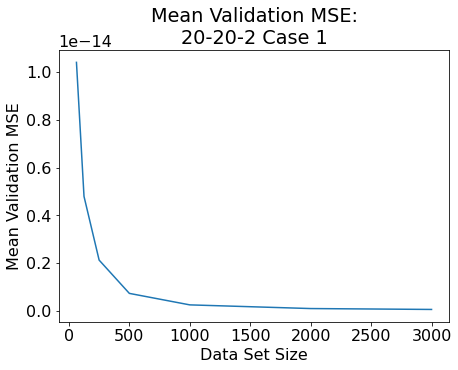

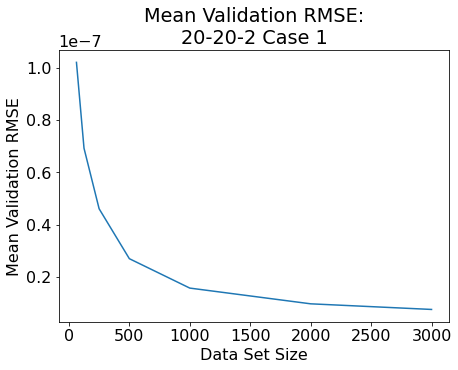

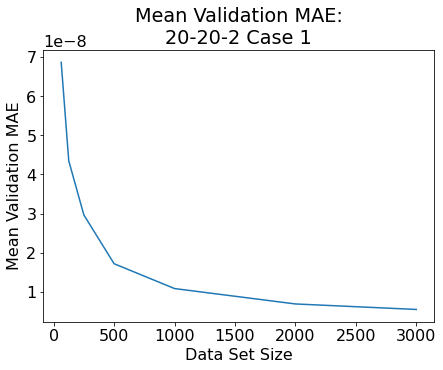

In [39]:
fig, ax = plt.subplots(1,1,figsize=(7,5))
plt.plot(plot_data_set_sizes, mean_val_mse_list)
plt.xlabel("Data Set Size")
plt.ylabel("Mean Validation MSE")
plt.title(f"Mean Validation MSE:\n{case}")
plt.savefig(f"{save_name}_val_mse_vs_data.png")
fig, ax = plt.subplots(1,1,figsize=(7,5))
plt.plot(plot_data_set_sizes, np.sqrt(mean_val_mse_list))
plt.xlabel("Data Set Size")
plt.ylabel("Mean Validation RMSE")
plt.title(f"Mean Validation RMSE:\n{case}")
plt.savefig(f"{save_name}_val_rmse_vs_data.png")
fig, ax = plt.subplots(1,1,figsize=(7,5))
plt.plot(plot_data_set_sizes, mean_val_mae_list)
plt.xlabel("Data Set Size")
plt.ylabel("Mean Validation MAE")
plt.title(f"Mean Validation MAE:\n{case}")
plt.savefig(f"{save_name}_val_mae_vs_data.png")

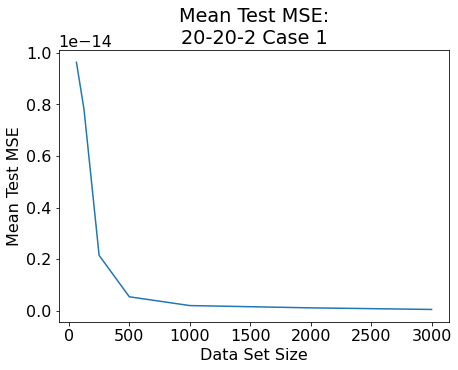

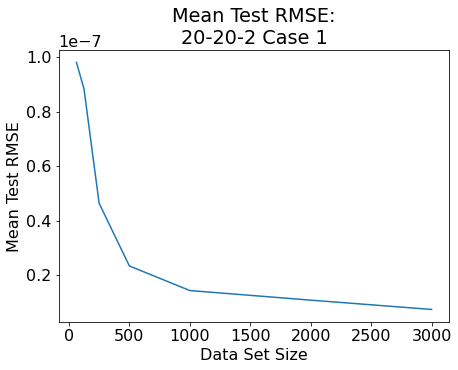

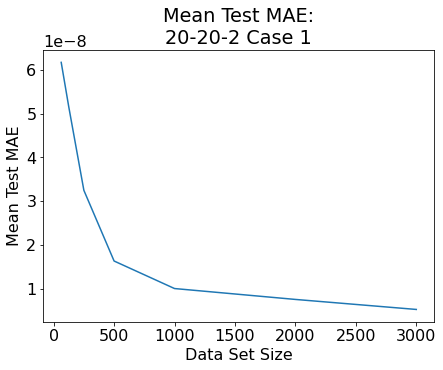

In [40]:
fig, ax = plt.subplots(1,1,figsize=(7,5))
plt.plot(plot_data_set_sizes, mean_test_mse_list)
plt.xlabel("Data Set Size")
plt.ylabel("Mean Test MSE")
plt.title(f"Mean Test MSE:\n{case}")
plt.savefig(f"{save_name}_test_mse_vs_data.png")
fig, ax = plt.subplots(1,1,figsize=(7,5))
plt.plot(plot_data_set_sizes, np.sqrt(mean_test_mse_list))
plt.xlabel("Data Set Size")
plt.ylabel("Mean Test RMSE")
plt.title(f"Mean Test RMSE:\n{case}")
plt.savefig(f"{save_name}_test_rmse_vs_data.png")
fig, ax = plt.subplots(1,1,figsize=(7,5))
plt.plot(plot_data_set_sizes, mean_test_mae_list)
plt.xlabel("Data Set Size")
plt.ylabel("Mean Test MAE")
plt.title(f"Mean Test MAE:\n{case}")
plt.savefig(f"{save_name}_test_mae_vs_data.png")